In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(5000)
tf.random.set_seed(5000)

In [2]:
tf.config.list_physical_devices('GPU')

[]

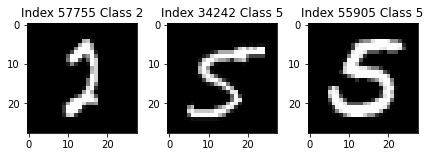

In [3]:
## Generate random data
#size_input = 32
#size_hidden = 128
#size_output = 1

#number_of_train_examples = 1000
#number_of_test_examples = 300

#X_train = np.random.randn(number_of_train_examples , size_input)
#y_train = np.random.randn(number_of_train_examples)
#X_test = np.random.randn(number_of_test_examples, size_input)
#y_test = np.random.randn(number_of_test_examples)

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [5]:
# Normalize Data
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 512
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [7]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input layer and 1st hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
    
    # Initialize weights between 2nd hidden layer and 3rd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3]))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden3]))
    
     # Initialize weights between 3rd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
    
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

  
 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, self.size_output)), dtype=tf.float32)
    #y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    
    #return tf.nn.softmax_cross_entropy_with_logits(labels=y_true_tf, logits=y_pred_tf)
    return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf)
    #return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    
    reg = (tf.math.reduce_sum(tf.square(self.W1)) + tf.math.reduce_sum(tf.square(self.W2)) + tf.math.reduce_sum(tf.square(self.W3)) + 
    tf.math.reduce_sum(tf.square(self.W4))) # L2 penalty
    #reg = (tf.math.reduce_sum(tf.abs(self.W1)) + tf.math.reduce_sum(tf.abs(self.W2)) + tf.math.reduce_sum(tf.abs(self.W3))) # L1 penalty
    current_loss = self.loss(predicted, y_train) + 0.0*reg       
        
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output)

 def stderr(self,y_pred):
    """
     Calculate standard error
     """
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    std_err = std_dev/sqrt(len(y_pred_tf))
    return std_err 


 def var(self,y_pred):
    """
     Calculate variance 
     """
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    variance = (std_dev**2) # calculate variance
    return variance 



Number of Epoch = 1 - Average Cross Entropy:= 14.53439875 
Number of Epoch = 2 - Average Cross Entropy:= 13.523765 
Number of Epoch = 3 - Average Cross Entropy:= 12.3640375 
Number of Epoch = 4 - Average Cross Entropy:= 11.68332375 
Number of Epoch = 5 - Average Cross Entropy:= 11.509765 
Number of Epoch = 6 - Average Cross Entropy:= 11.65479 
Number of Epoch = 7 - Average Cross Entropy:= 11.65473625 
Number of Epoch = 8 - Average Cross Entropy:= 11.087825 
Number of Epoch = 9 - Average Cross Entropy:= 10.54873 
Number of Epoch = 10 - Average Cross Entropy:= 10.44783625 
Number of Epoch = 11 - Average Cross Entropy:= 10.424985625 
Number of Epoch = 12 - Average Cross Entropy:= 10.0732425 
Number of Epoch = 13 - Average Cross Entropy:= 10.286684375 
Number of Epoch = 14 - Average Cross Entropy:= 10.344136875 
Number of Epoch = 15 - Average Cross Entropy:= 9.929369375 
Number of Epoch = 16 - Average Cross Entropy:= 9.97006875 
Number of Epoch = 17 - Average Cross Entropy:= 9.854531875 
N

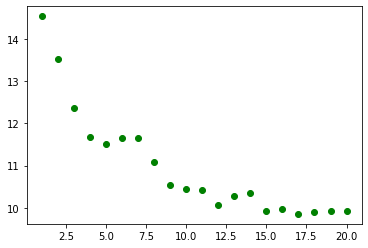

In [8]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='cpu')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5000)).batch(20)

  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs) 
    
    #print(preds.shape)
    #print(outputs.shape)
    
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
  
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    
preds_val = mlp_on_cpu.forward(X_val)
correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_val_acc = accuracy.numpy()

print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


In [9]:
# Random seed
np.random.seed(5000*2)
tf.random.set_seed(5000*2)

# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
cur_val_acc = tf.Variable(0, dtype=tf.float32)
cur_tes_acc = tf.Variable(0, dtype=tf.float32)
acc_preds = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))


# Test model
preds_test = mlp_on_cpu.forward(X_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()

#for i in range(preds.shape[0]):
#    if tf.argmax(preds[i])==tf.argmax(y_test[i]):
#        acc_preds = acc_preds + 1.0
#        acc = (acc_preds/X_test.shape[0])*100.0


print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

        
 # standard_error = mlp_on_cpu.stderr(preds) # Standard error
  #Variance = mlp_on_cpu.var(preds) # Variance


#print('Inference 1st')
#print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy())/X_train.shape[0]))
#print('Accuracy: {:.4f}'.format(acc))
#print('Standard Error: {:.4f}'.format(standard_error))
#print('Variance: {:.4f}'.format(Variance))



Test loss: 1.9719

Test Accuracy: 0.39
